# Analysis of extrinsic results

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import lisa_cluster

from src import plotting_functions as plot_func

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/paths.py

/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_dk_analysis/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases 

In [2]:
# Import summary dataframe
summarize_ex_results_df = pd.read_csv(f"../results/COMPARE/{study_area}/data/extrinsic_summary_results.csv",index_col=0)

summarize_ex_results_df.style.pipe(format_extrinsic_style)

In [3]:
# Import summary dataframe
summarize_fm_results_df = pd.read_csv(
    f"../results/COMPARE/{study_area}/data/feature_matching_summary_stats.csv",
    index_col=0,
)

summarize_fm_results_df.style.pipe(format_matched_style)


In [4]:
# TODO: Analyze SPATIAL PATTERN in differences in density

# TODO: Analyze SPATIAL PATTERN in differences in matched features

# TODO: Find a way to compare differences in density to matched features

# TODO: Analysis of overlap between errors and differences.

# TODO: Analysis of correlation between high/low quality areas and pop density

# TODO: Make plotting optional

In [5]:
make_plots = True

In [20]:
# Create/load spatial weights

%run ../settings/create_extrinsic_grid_spatial_weights.py

adj_list = pd.read_csv(extrinsic_grid_spatial_weights_fp)

w = weights.W.from_adjlist(adj_list)

/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 17 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 17 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


## Spatial patterns in density differences

In [7]:
# Read extrinsic grid results
with open(
    compare_results_data_fp + f"grid_results_extrinsic.pickle", "rb"
) as fp:
    extrinsic_grid = pickle.load(fp)

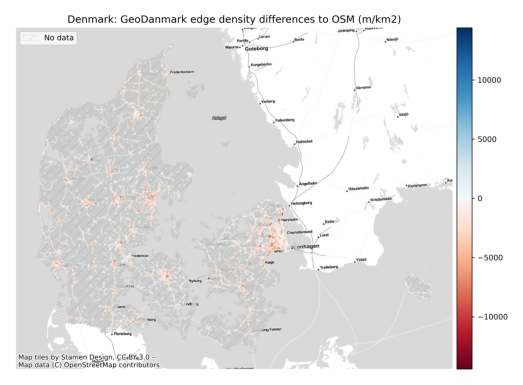

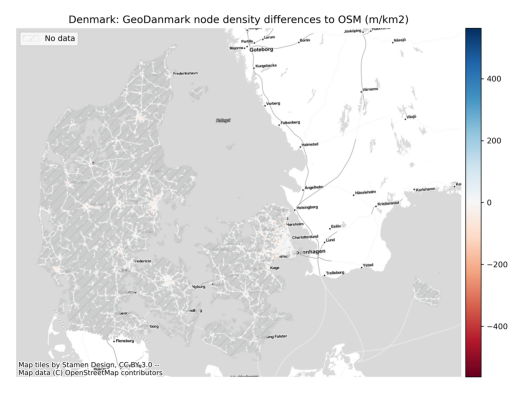

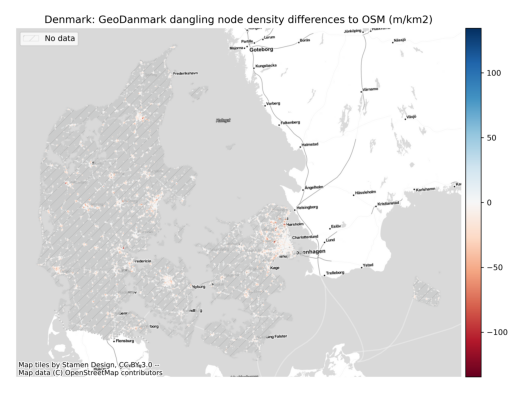

In [8]:
filepaths = [
    compare_results_static_maps_fp + "edge_density_compare",
    compare_results_static_maps_fp + "node_density_compare",
    compare_results_static_maps_fp + "dangling_node_density_compare",
]

for f in filepaths:

    plot_func.plot_saved_maps(filepaths=[f])

In [25]:
def compute_spatial_autocorrelation(col_names, variable_names, df, spatial_weights):

    morans = {}

    for c, v in zip(col_names, variable_names):

        # compute spatial lag
        df[f"{v}_lag"] = weights.spatial_lag.lag_spatial(
            spatial_weights, df[c]
        )

        _, ax = plt.subplots(1, figsize=(7,7))

        sns.regplot(
            x=c,
            y=f"{v}_lag",
            ci=None,
            data=df,
            line_kws={"color": "r"},
            scatter_kws={"alpha": 0.4},
            color="black",
        )

        ax.axvline(0, c="k", alpha=0.5)
        ax.axhline(0, c="k", alpha=0.5)
        ax.set_title(f"Moran Plot - {v}")
        plt.show()

        moran = esda.moran.Moran(df[c], spatial_weights)
        print(f"With significance {moran.p_sim}, the Moran's I value for differences in {v} is {moran.I}" )

        morans[v] = moran

        # TODO: save figs

    return morans



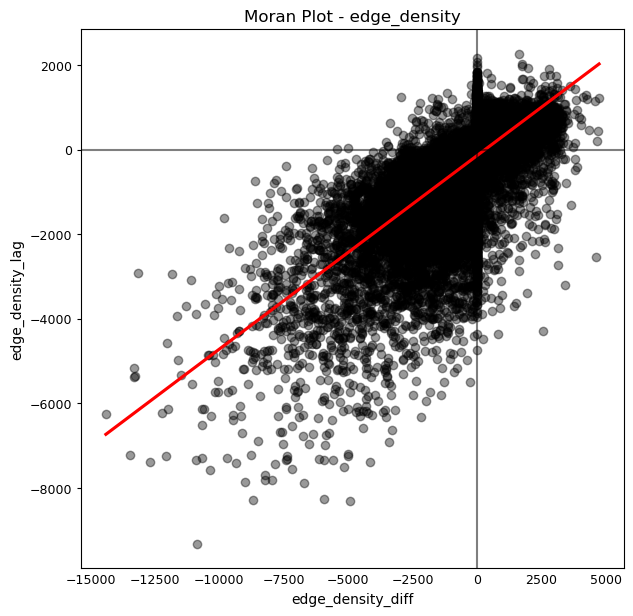

With significance 0.001, the Moran's I value for differences in edge_density is 0.45774949898526224


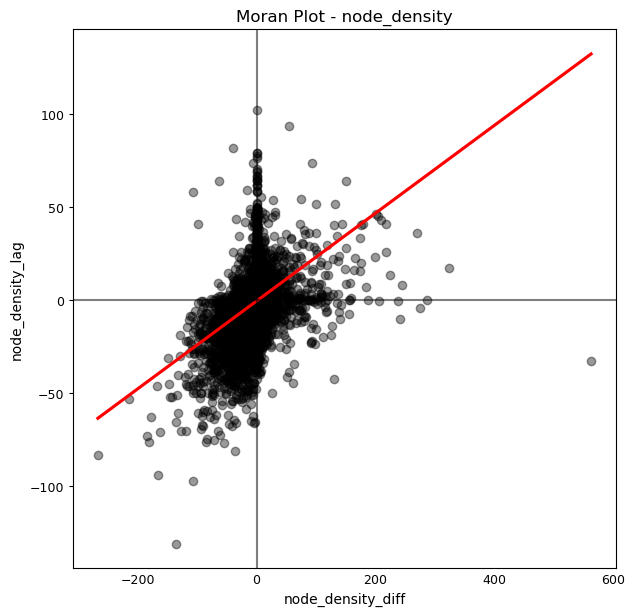

With significance 0.001, the Moran's I value for differences in node_density is 0.2360179729683504


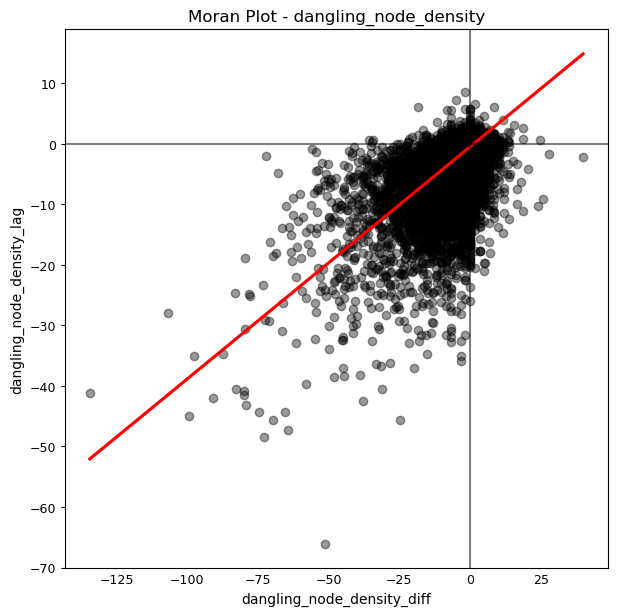

With significance 0.001, the Moran's I value for differences in dangling_node_density is 0.38360888094275625


In [26]:
col_names = ['edge_density_diff','node_density_diff','dangling_node_density_diff']
variable_names = ["edge_density","node_density","dangling_node_density"]

morans_density = compute_spatial_autocorrelation(col_names, variable_names, extrinsic_grid, w)

In [30]:
def compute_lisa(col_names, variable_names, gdf, spatial_weights, p=0.05):

    # based on https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

    lisas = {}

    significance_labels = {}

    for v, c in zip(variable_names,col_names):

        lisa = esda.moran.Moran_Local(gdf[c], spatial_weights)

        lisas[v] = lisa

        sig = 1 * (lisa.p_sim < p)

        spots = lisa.q * sig

        # Mapping from value to name (as a dict)
        spots_labels = {
            0: "Non-Significant",
            1: "HH",
            2: "LH",
            3: "LL",
            4: "HL",
        }
        gdf[f"{v}_q"] = pd.Series(
            spots,
            index=gdf.index
            ).map(spots_labels)

        f, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
        axs = axs.flatten()

        ax = axs[0]

        gdf.assign(
            Is=lisa.Is
        ).plot(
            column="Is",
            cmap="plasma",
            scheme="quantiles",
            k=2,
            edgecolor="white",
            linewidth=0.1,
            alpha=0.75,
            legend=True,
            ax=ax,
        )

        ax = axs[1]

        lisa_cluster(lisa, gdf, p=1, ax=ax)

        ax = axs[2]
        labels = pd.Series(
            1 * (lisa.p_sim < p), 
            index=gdf.index  
        ).map({1: "Significant", 0: "Non-Significant"})
        gdf.assign(
            cl=labels
        ).plot(
            column="cl",
            categorical=True,
            k=2,
            cmap="Paired",
            linewidth=0.1,
            edgecolor="white",
            legend=True,
            ax=ax,
        )

        significance_labels[v] = labels

        ax = axs[3]
        lisa_cluster(lisa, gdf, p=p, ax=ax)

        for i, ax in enumerate(axs.flatten()):
            ax.set_axis_off()
            ax.set_title(
                [
                    "Local Statistics",
                    "Scatterplot Quadrant",
                    "Statistical Significance",
                    "Moran Cluster Map",
                ][i],
                y=0,
            )

        f.suptitle(f'Local Spatial Autocorrelation for differences in: {v}', fontsize=16)

        f.tight_layout()

        plt.show()

        # TODO: Save figs

    return lisas


In [ ]:
# TODO: write function, instead of script, for computing spatial weights - define type of spatial weight centrally??
# - should allow for custom definition of cols to drop for computation of weights - i.e. no data cols

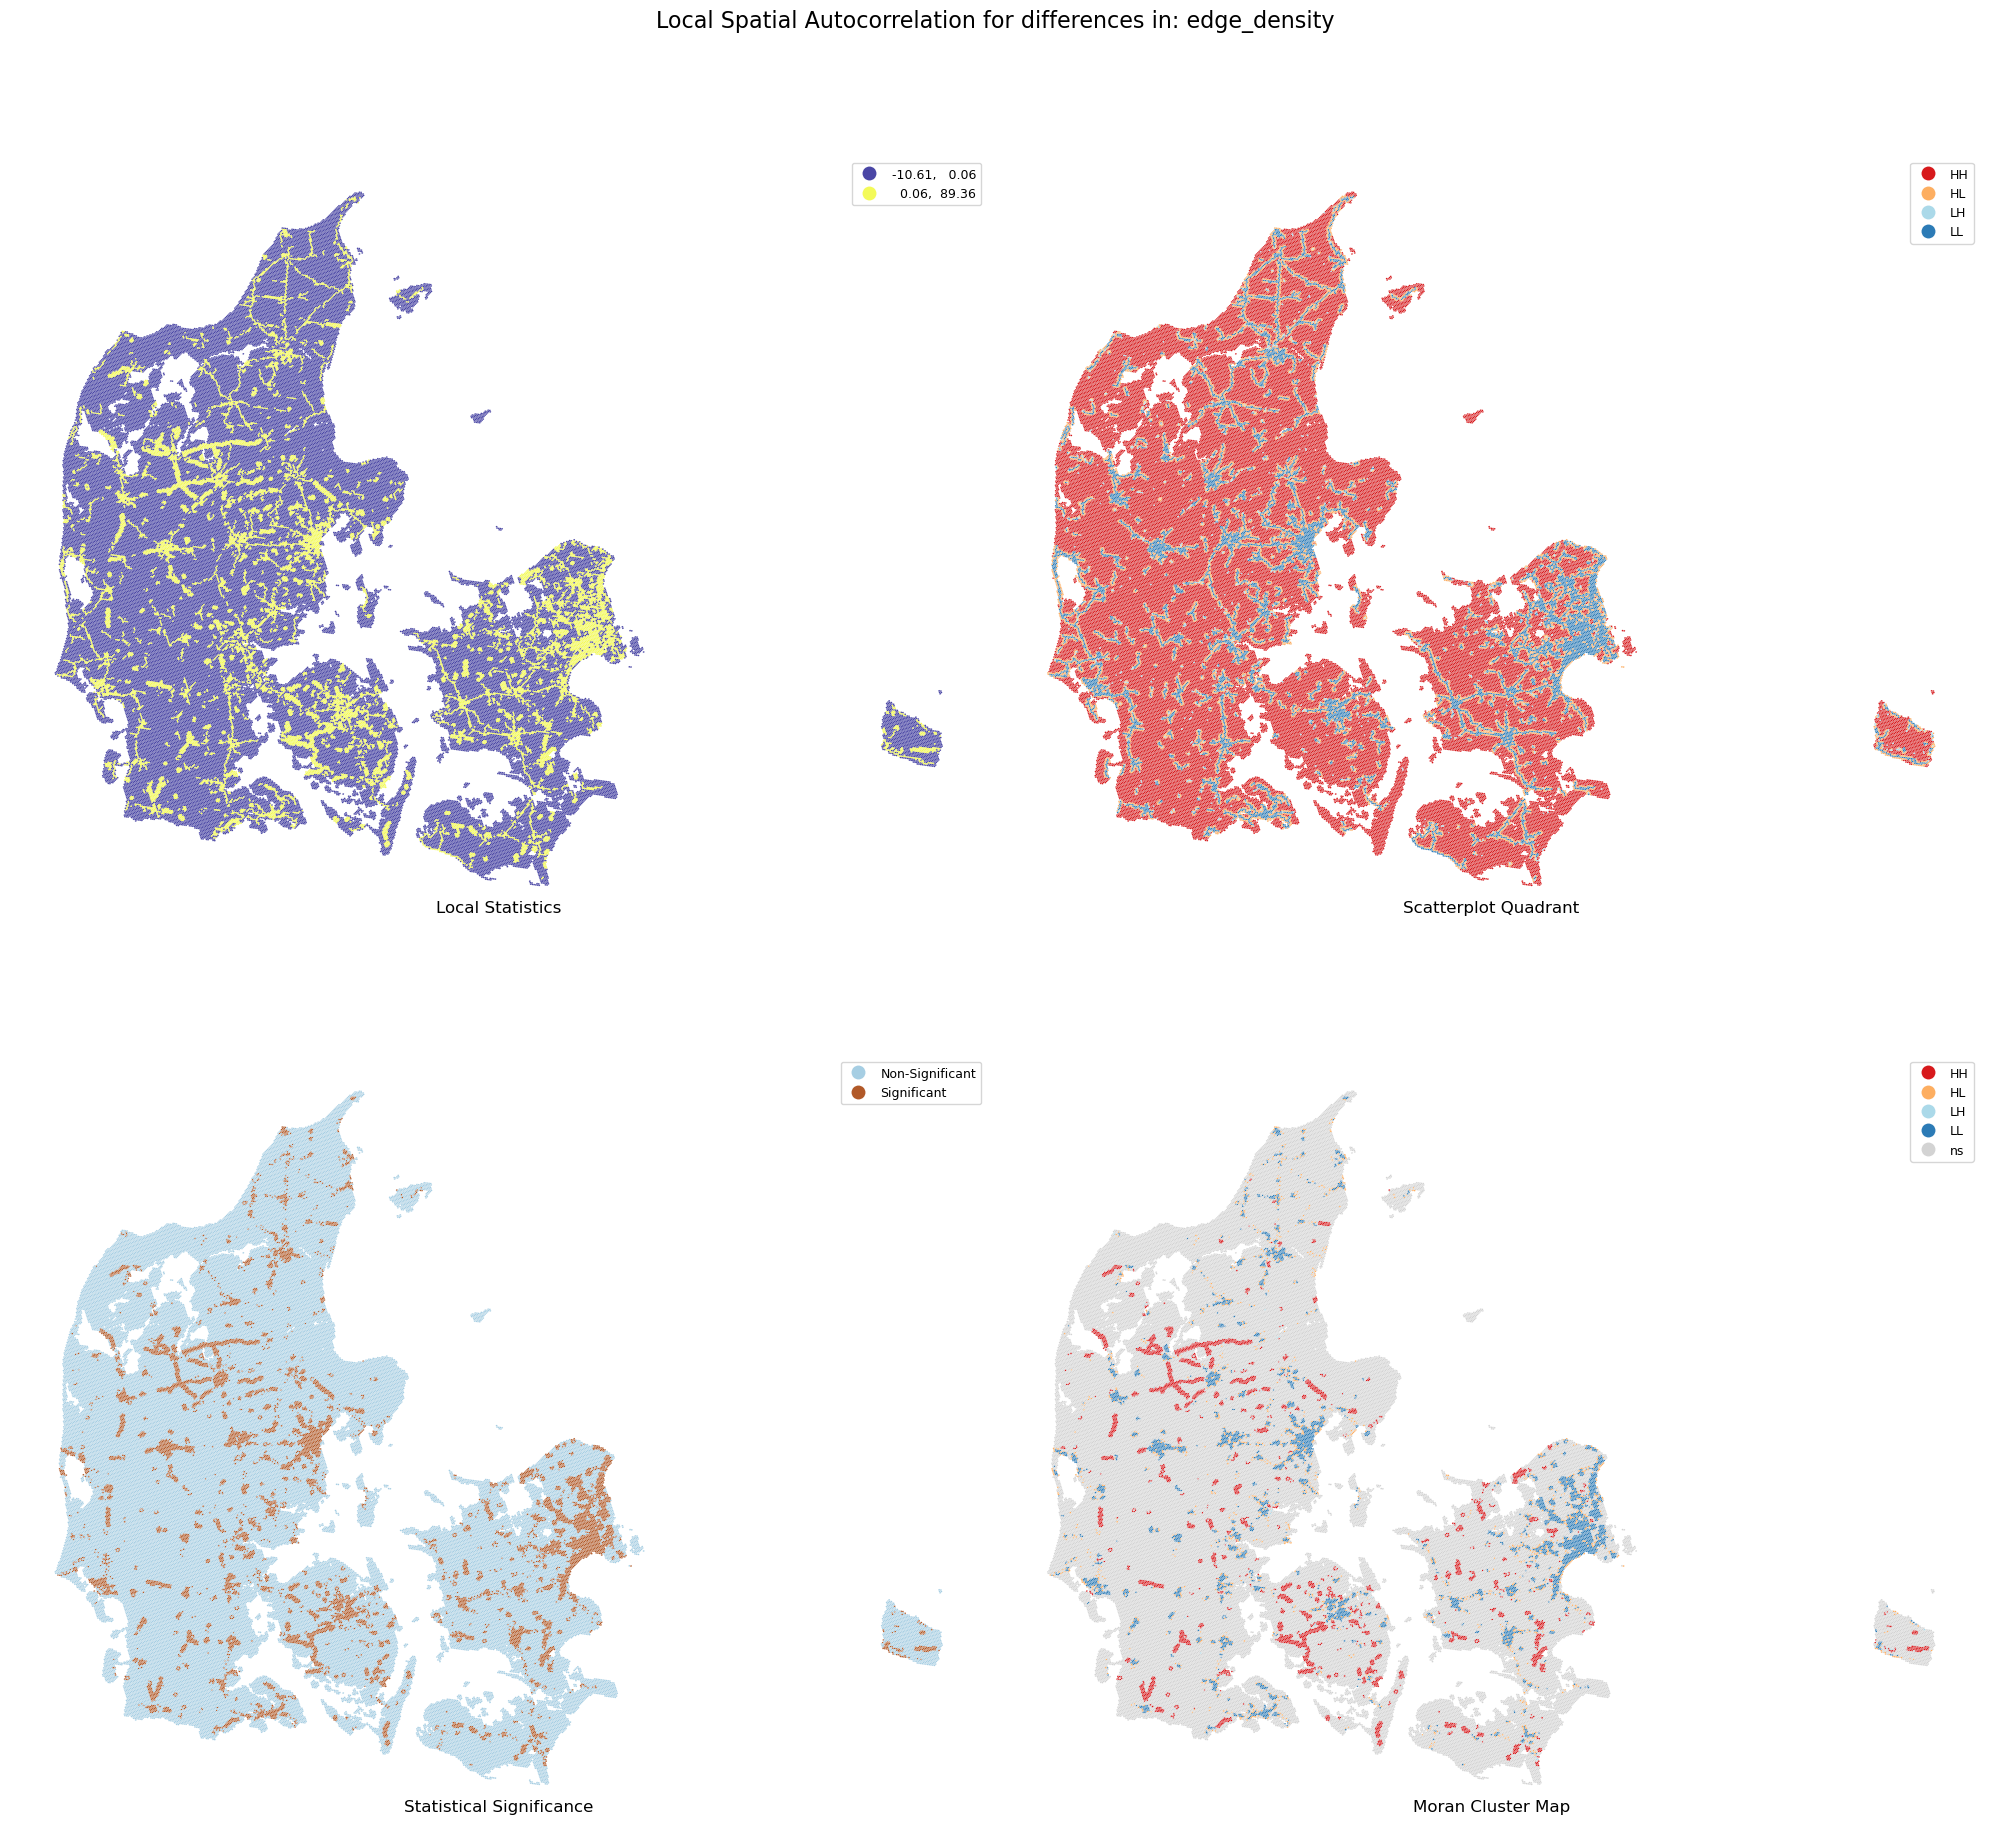

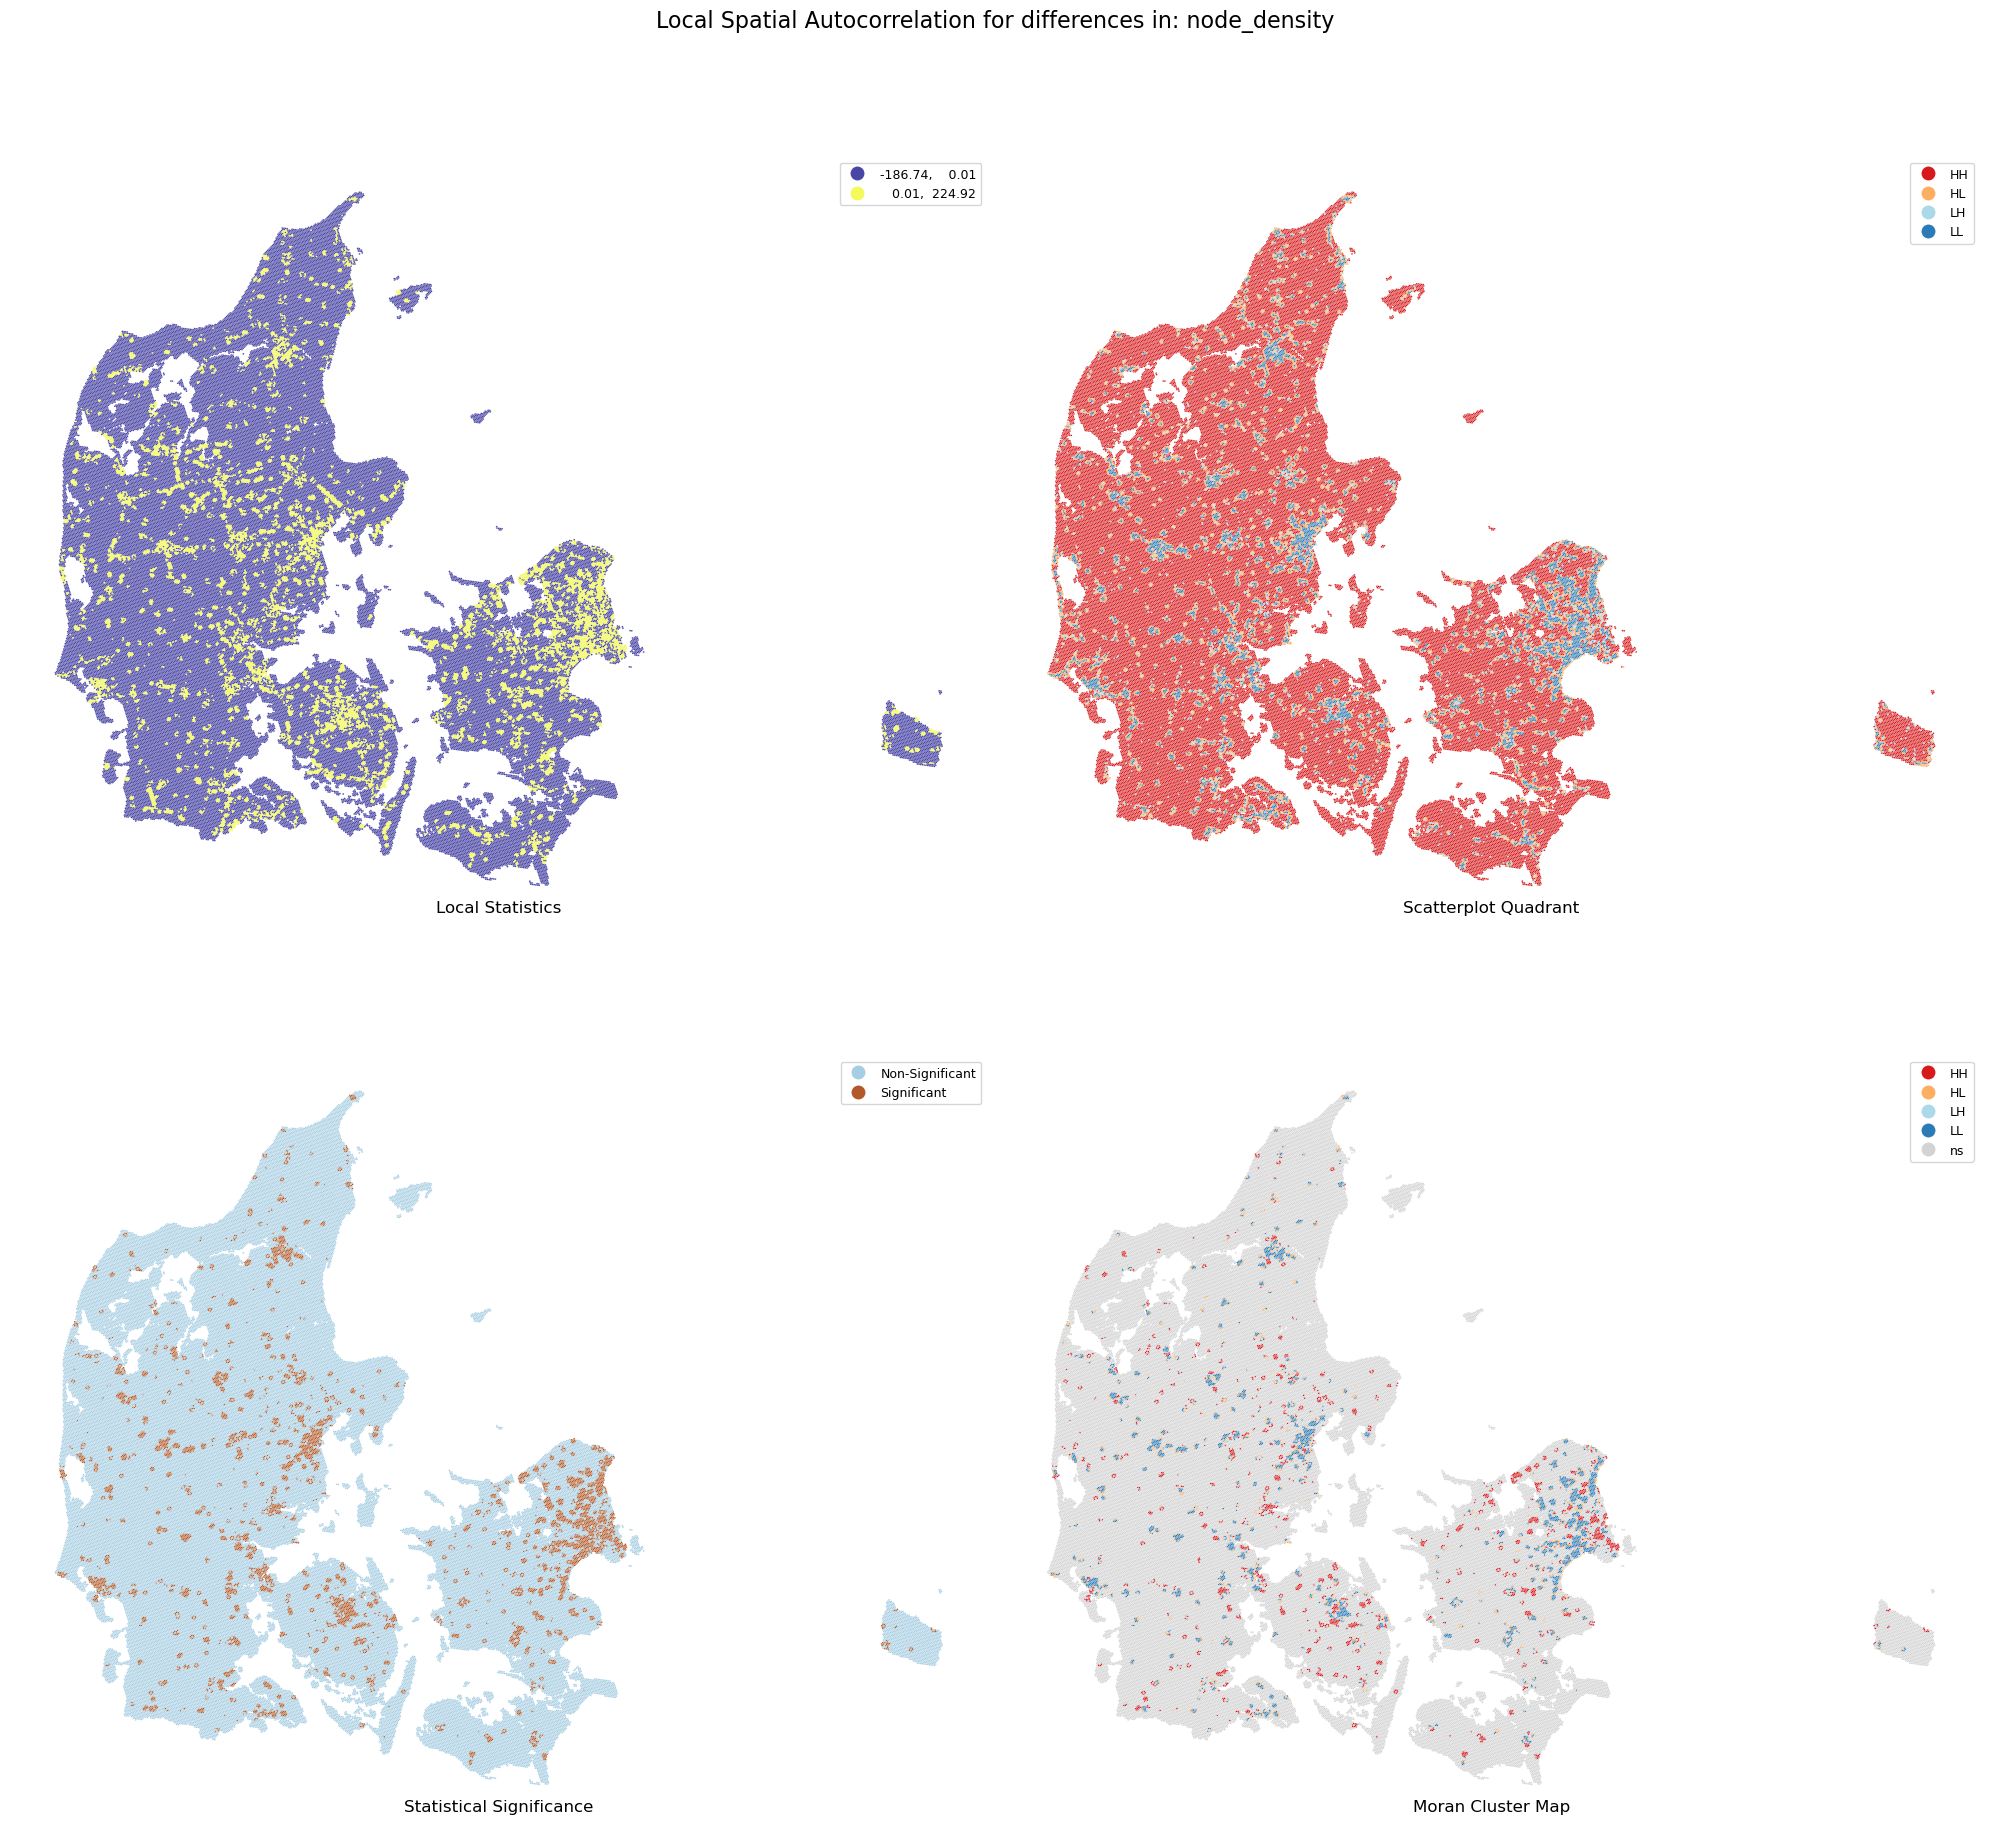

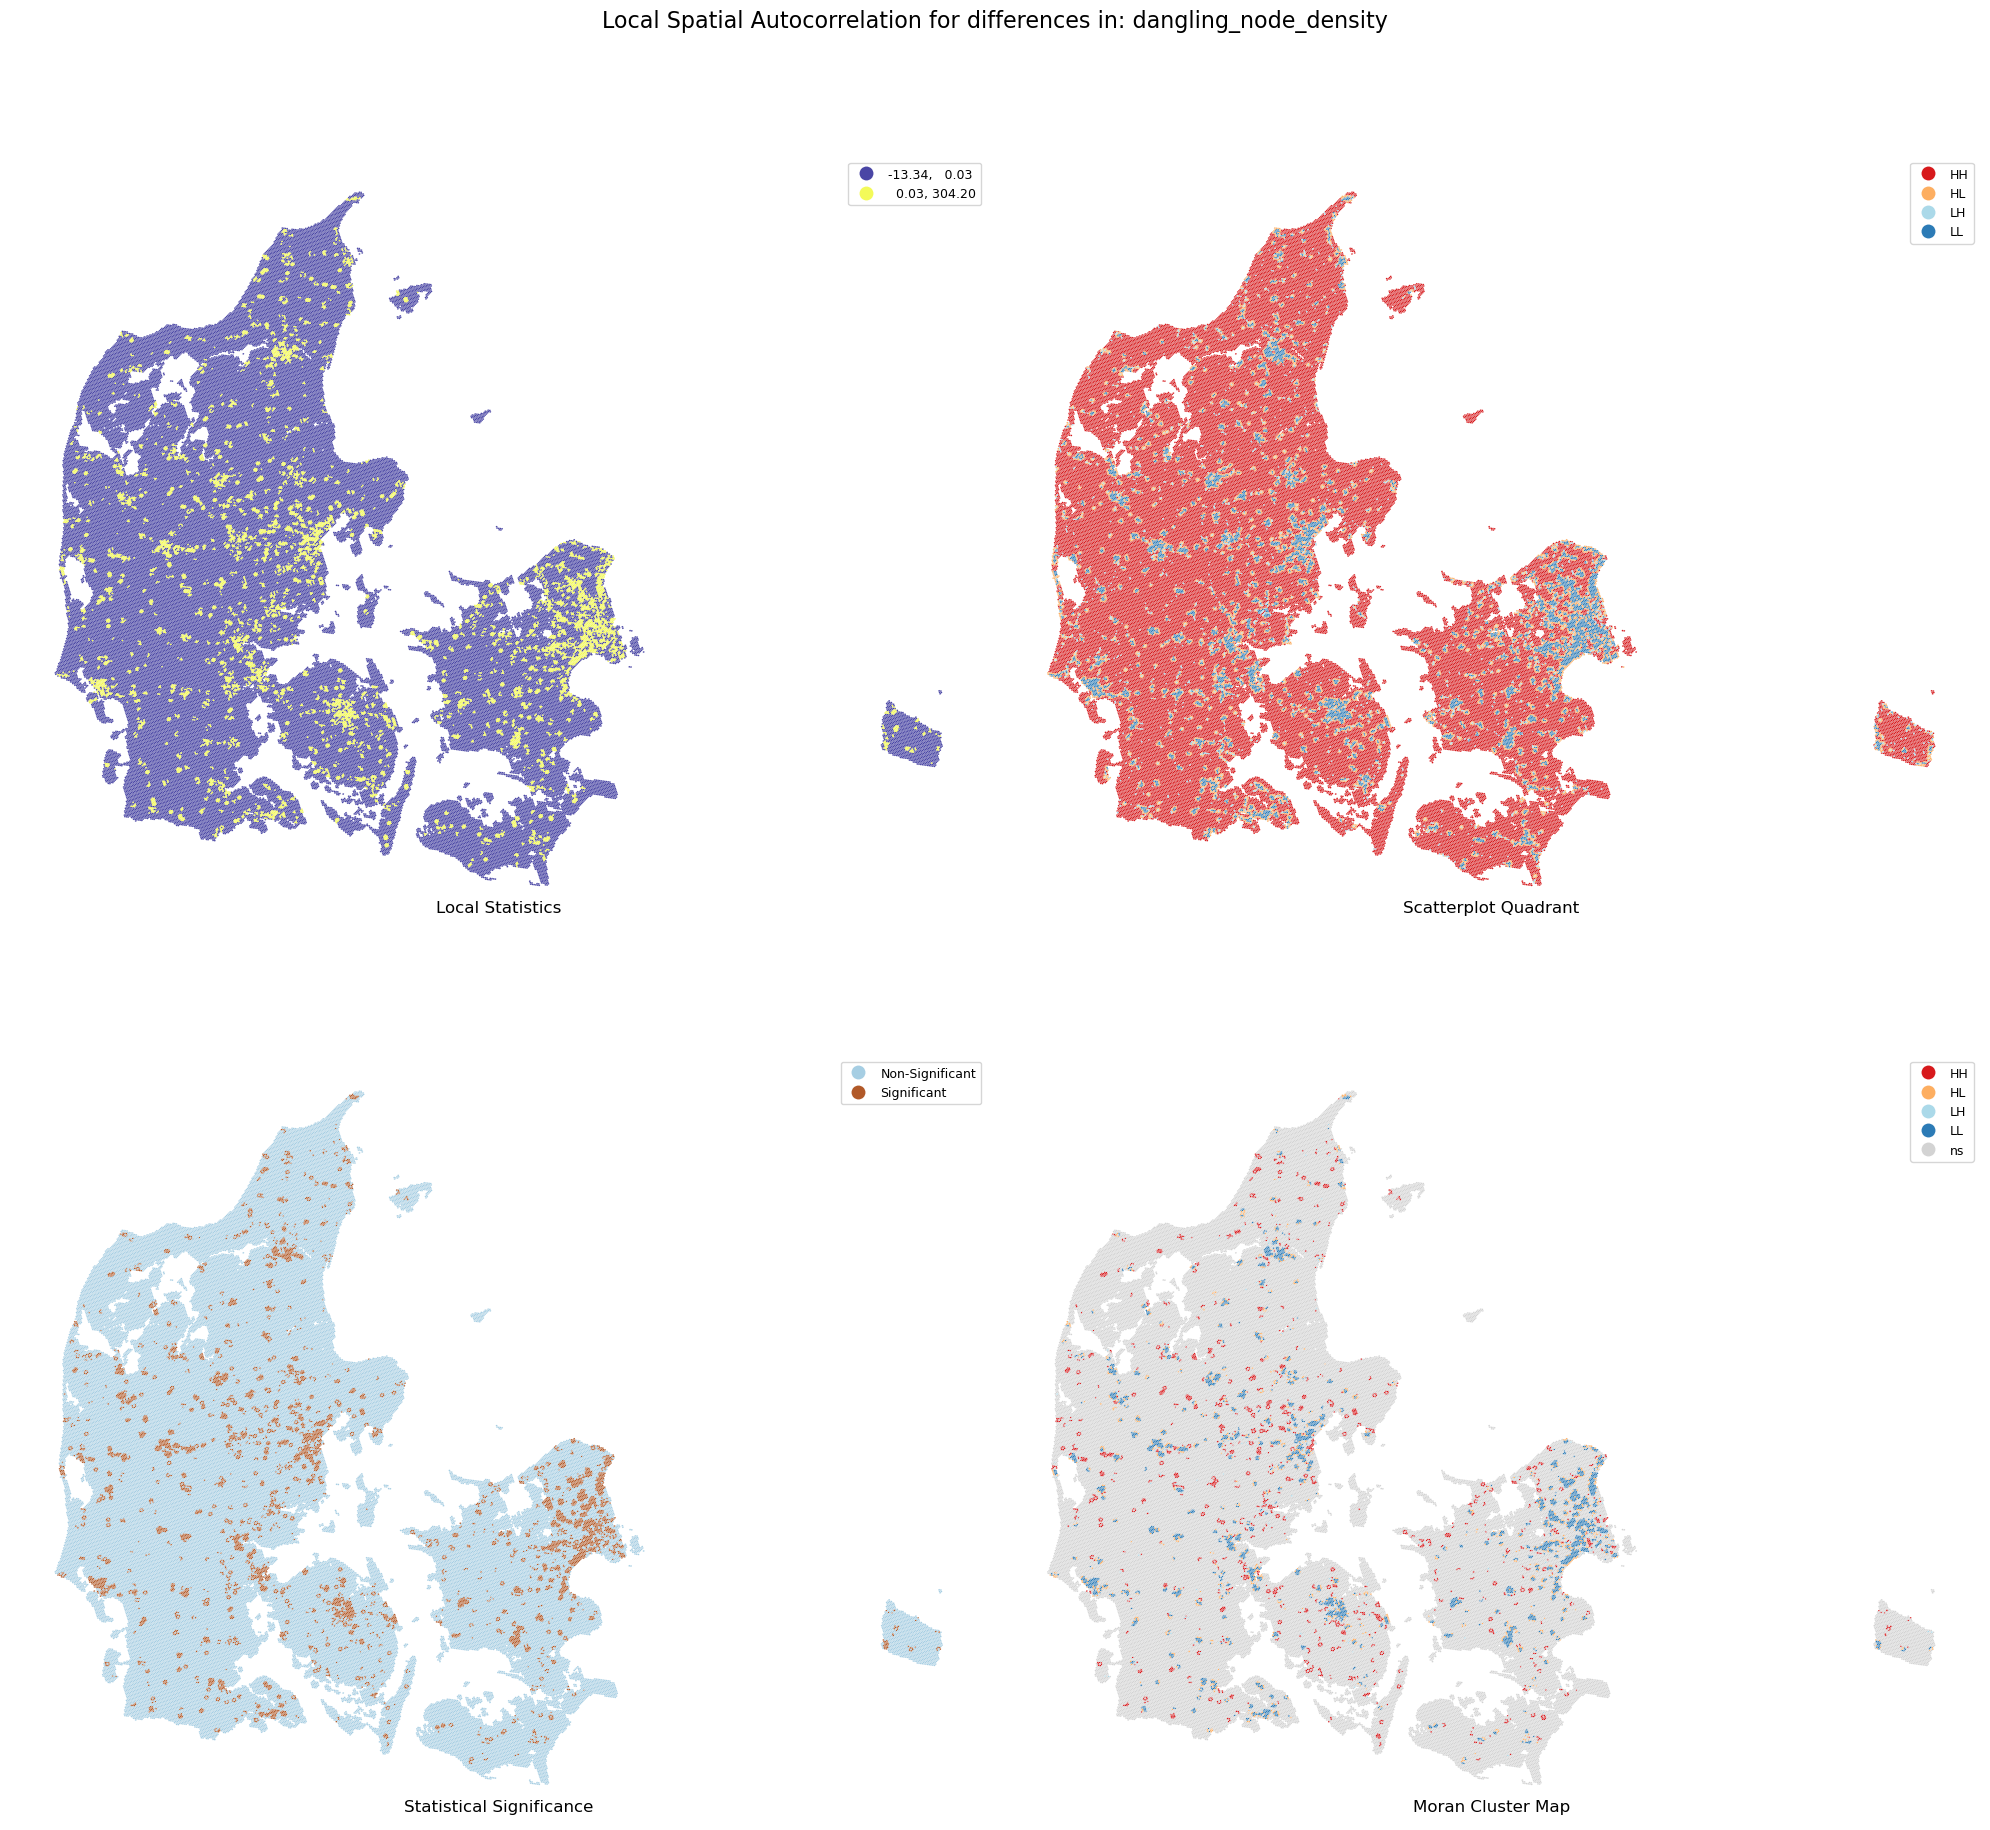

In [31]:
col_names = ['edge_density_diff','node_density_diff','dangling_node_density_diff']
variable_names = ["edge_density","node_density","dangling_node_density"]

lisas_density = compute_lisa(col_names, variable_names, extrinsic_grid, w)

## Spatial patterns in matching success

In [10]:
# TODO: LOAD PLOTS

In [11]:
# TODO: analyse spatial auto

## Differences between density and matching differences

### IDENTIFY WHERE DENSITY DIFF IS LOW BUT HIGH RATE OF UNMATCHED